# 1. Lecture CSV

In [1]:
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, recall_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
data_train = pd.read_csv("../datas/conversion_data_train_EDA.csv")
data_train.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


# 2. Baseline sur Train

Grâce à l'EDA, nous avons constaté qu'une des variables importante pour prédire `converted` est `total_pages_visited`. 

Nous allons donc créer un premier modèle qui utilise uniquement cette variable.

On sépare les données en 2 : 1 set d'entrainement (80% des données), 1 set de test (20% des données)

In [3]:
target = "converted"
to_drop = ["country", "age", "new_user", "source", "converted"]
x = data_train.drop(columns=to_drop) 
y = data_train[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

display(x.head())
print("y :", y)

,total_pages_visited
0,2
1,3
2,14
3,3
4,3


y : 0         0
1         0
2         1
3         0
4         0
         ..
283558    0
283559    0
283560    0
283561    0
283562    0
Name: converted, Length: 283563, dtype: int64


Préprocessing : Standardisation / Mise à l'échelle des données

In [4]:
numerical_columns = x_train.select_dtypes(include=["float", "int"]).columns
print("numerical_columns :", numerical_columns)

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns)
    ])

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test) 

numerical_columns : Index(['total_pages_visited'], dtype='object')


### Modèle de regression logistique

#### Entrainement du modèle et prédiction

In [5]:
# Train model
lr = LogisticRegression()
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

In [6]:
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

f1-score on training set :  0.6967457946863701
f1-score on test set :  0.6897856242118537

recall_score on training set :  0.603979285908967
recall_score on test set :  0.5961852861035423


#### Validation croisée

In [7]:
scores = cross_val_score(lr, x_train, y_train, cv=3)
print("The cross-validated mean score is : ", scores.mean())
print("The standard deviation is : ", scores.std())

The cross-validated mean score is :  0.9829931672905006
The standard deviation is :  0.0002483492213742222


#### Résumé des performances

In [8]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    219512
           1       0.82      0.60      0.70      7338

    accuracy                           0.98    226850
   macro avg       0.91      0.80      0.84    226850
weighted avg       0.98      0.98      0.98    226850



#### Matrices de confusion

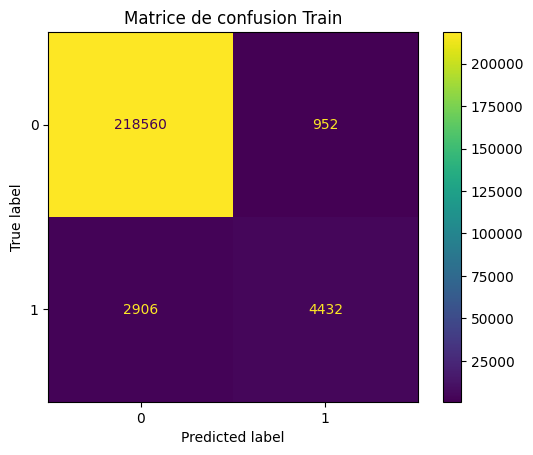

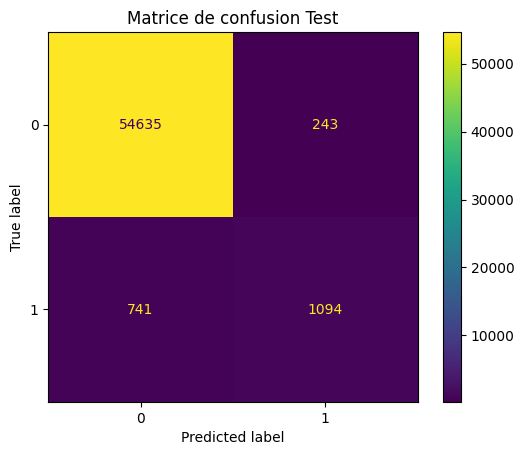

In [9]:
_, ax = plt.subplots()
ax.set(title="Matrice de confusion Train")
ConfusionMatrixDisplay.from_estimator(lr, x_train, y_train, ax=ax)
plt.show()

_, ax = plt.subplots()
ax.set(title="Matrice de confusion Test")
ConfusionMatrixDisplay.from_estimator(lr, x_test, y_test, ax=ax)
plt.show()

#### Courbes ROC

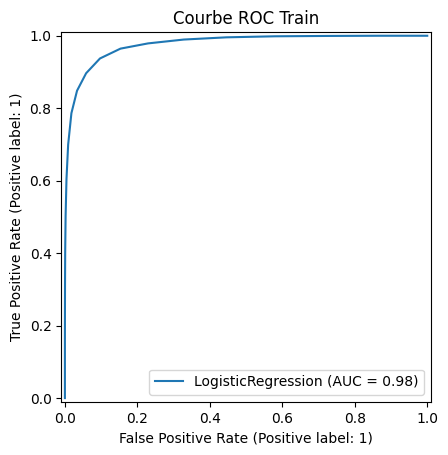

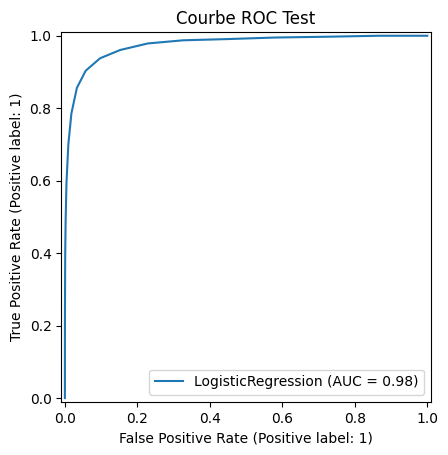

In [10]:
_, ax = plt.subplots()
ax.set(title="Courbe ROC Train")
RocCurveDisplay.from_estimator(lr, x_train, y_train, ax=ax)
plt.show()

_, ax = plt.subplots()
ax.set(title="Courbe ROC Test")
RocCurveDisplay.from_estimator(lr, x_test, y_test, ax=ax)
plt.show()

#### Conclusion

Déséquilibre des classes très marqué : la classe 0 est très bien prédite, mais la classe 1 est détectée avec beaucoup moins de succès.

Bonne stabilité du modèle (faible écart-type en validation croisée).

Ces résultats soulignent la nécessité de prendre en compte le déséquilibre des classes.

----

# 3. Prédictions sur Test

In [11]:
data_test = pd.read_csv("../datas/conversion_data_test_EDA.csv")

to_drop = ["country", "age", "new_user", "source"]

x_test = data_test.drop(columns=to_drop)
x_test = preprocessor.transform(x_test)

y_test = pd.read_csv("../datas/conversion_data_test_labels_EDA.csv")
y_pred = lr.predict(x_test)

print("f1-score on set without labels : ", f1_score(y_test, y_pred))
print()
print("recall_score on set without labels : ", recall_score(y_test, y_pred))

f1-score on set without labels :  0.6950596252129472

recall_score on set without labels :  0.6017699115044248


---

Sauvegarde des résultats dans un dataframe

In [12]:
scores_df = pd.DataFrame(columns = ["model", "f1", "recall"])
new_rows = [{"model": "baseline", "f1": f1_score(y_test, y_pred), "recall": recall_score(y_test, y_pred)}]
scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
scores_df.to_csv("../datas/scores.csv", mode="w", index=False)

/tmp/ipykernel_25389/2861940084.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
